In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.multioutput import ClassifierChain
from sklearn.metrics import precision_recall_fscore_support
from preprocess import *
import warnings
warnings.filterwarnings(action='ignore')
from sklearn.naive_bayes import ComplementNB
from sklearn.tree import DecisionTreeClassifier
import shap
import plotly.graph_objects as go
import tqdm

In [2]:
output_cols = ['OffAge','Relationship','OffSex', 'OffRace', 'OffEthnic','OffCount']

# converts a non-numeric column to a numeric column
def col_numeric(X,col):
  xcol = X[col]
  if str(xcol.dtypes) == 'object' or str(xcol.dtypes)== 'category' or str(xcol.dtypes)== 'string':
      labels = xcol.unique()
      mapping = dict(zip(labels,range(0,len(labels))))
      X.replace({col: mapping},inplace=True)
  if str(xcol.dtypes) == 'uint8':
        X[col] =  X[col].astype("int64")
        
def preprocess(df):
  df["VicAge"]= bin_age(df,"VicAge")
  # df["OffAge"] = bin_age(df,"OffAge")
  # "County","State",'Area','Agency'
  input_cols = ['Agentype', 'Year', 'Month','Homicide', 'VicAge', 'VicSex', 'VicRace', 'VicEthnic','Weapon', 'Circumstance', 'Subcircum', 'VicCount']
  X = df[input_cols]

  # creating dummy variables
  # to_dummy = ["County","State",'Area','Agency', 'Agentype','VicRace', 'VicAge','VicEthnic','Weapon', 'Circumstance', 'Subcircum']
  to_dummy = ['Agentype','VicRace','VicEthnic','Weapon', 'Circumstance', 'Subcircum']
  dumies = pd.get_dummies(df[to_dummy])
  dummied = df[input_cols].drop(to_dummy,axis = 1)
  X = dummied.join(dumies)
  X = to_numeric(X)
  col_numeric(X,"VicAge")
  X["Year"] = (X["Year"] - X["Year"].min())/ (X["Year"].max() - X["Year"].min())
  X["Month"] = (X["Month"] - X["Month"].min())/ (X["Month"].max() - X["Month"].min())

  Y = df[output_cols]
    # creating dummy variables

  to_dummy = ['OffAge','Relationship','OffSex', 'OffRace', 'OffEthnic']
  dumies = pd.get_dummies(df[to_dummy])
  dummied = df[output_cols].drop(to_dummy,axis = 1)
  Y = dummied.join(dumies)
  Y['OffCount'][Y['OffCount']>0] = 'multiple off'
  Y['OffCount'][Y['OffCount']==0] ='single off'

  Y = to_numeric(Y)

  return [X,Y]


In [3]:
# df = pd.read_csv('/content/drive/MyDrive/DKE/project 1-1/ecc/train_subset.csv',index_col=0) 
# df_val = pd.read_csv('/content/drive/MyDrive/DKE/project 1-1/ecc/validation_subset',index_col=0) 
# df_test = pd.read_csv('/content/drive/MyDrive/DKE/project 1-1/ecc/test_subset',index_col=0) 
df = pd.read_csv('train_subset',index_col=0) 
df_val = pd.read_csv('validation_subset',index_col=0) 
df_test = pd.read_csv('test_subset',index_col=0) 
print("test ",len(df_test))
print("val ",len(df_val))
print("train ",len(df))
df_all = df.merge(df_val, how = 'outer').merge(df_test, how = 'outer')

test_index = df_test.index
train_index = df.index
val_index = df_val.index
[X,Y] = preprocess(df_all)

X_train = X.iloc[train_index]
Y_train = Y.iloc[train_index]
X_test = X.iloc[test_index]
Y_test = Y.iloc[test_index]
X_val = X.iloc[val_index]
Y_val = Y.iloc[val_index]
# print(Y.columns[:1])
# print(Y.columns[1:13])
# print(Y.columns[13:42])
# print(Y.columns[42:44])
# print(Y.columns[44:49])
# print(Y.columns[49:52])

test  28442
val  5815
train  79697


In [4]:
def get_w_average(metric,support):
    new_metrics = []
    spliters = [0,1,13,42,44,49,52]
    for m in range(3):
        m_e = []
        for i in range(len(output_cols)):
            s1 = spliters[i]; s2 = spliters[i+1]
            m_e.append(np.average(metric[m][s1:s2], weights = support[s1:s2]))
        new_metrics.append(m_e)
        
    return new_metrics
            

def build_model(base):
    chain_log = ClassifierChain(base, order='random', random_state=0)
    model = chain_log.fit(X_train, Y_train)
    Y_hat = model.predict(X_test)
    metrics = list(precision_recall_fscore_support(Y_test,Y_hat))
    # metrics.append(model.score(X_test,Y_test))
    # multi output?
    print(get_w_average(metrics[0:3],metrics[3]))
    # print(accuracy_score(X_test,Y_test))
    # print(balanced_accuracy_score(X_test,Y_test))
    return model

def build_ensemble(base,nb=10):
    chains = [ClassifierChain(base, order="random", random_state=i) for i in range(nb)]
    for chain in chains:
        chain.fit(X_train, Y_train)
    return chains

In [8]:
base_lr = LogisticRegression(solver='lbfgs', random_state=0,class_weight = 'balanced',max_iter=75)
model_lr = build_model(base_lr)

[[0.3689878616409601, 0.17422996991995943, 0.3231346299268823, 0.7970849967258531, 0.8561896048904427, 0.9261715232559605], [0.6132261489458517, 0.23648126010829057, 0.15297799029604106, 0.7401729836157794, 0.8225159974685324, 0.9282750861402151], [0.46074074074074073, 0.20047434174466955, 0.12482174499023747, 0.7630081251482882, 0.8332430321178208, 0.926185001671533]]


In [5]:
#base_lr=svm.SVC()
#base_lr = ComplementNB()
base_dt =DecisionTreeClassifier(max_depth=30)
chains = build_ensemble(base_dt,10)
Y_pred_chains = np.array([chain.predict(X_test) for chain in chains])
Y_hat = np.rint(Y_pred_chains.mean(axis=0))
metrics = list(precision_recall_fscore_support(Y_test,Y_hat))
get_w_average(metrics[0:3],metrics[3])


[[0.9921341337197268,
  0.9518314186841877,
  0.928506469733853,
  0.9731469007778749,
  0.9721080503871339,
  0.9903605519165065],
 [0.7269831639617776,
  0.7896420786161311,
  0.8013852752970958,
  0.9626608536671121,
  0.9619576682371141,
  0.9852331059700443],
 [0.8391106442577031,
  0.8602213274727546,
  0.8530083046325753,
  0.9658392688584748,
  0.9668752123768753,
  0.9877626925582065]]

In [18]:
base_cb = ComplementNB()
model_cb = build_model(base_cb)

[[0.3378670509818051, 0.17177313461321556, 0.3378694640755605, 0.8003463887785583, 0.8008696066352665, 0.9148984168063174], [0.5689367510996511, 0.23714928626678855, 0.18272273398495184, 0.7369031713662892, 0.7524084100977427, 0.9168834821742493], [0.4239615710652727, 0.19893158918604797, 0.11728524760797782, 0.7616952463839346, 0.758824593643172, 0.9150270441452772]]


In [64]:
chain_sizes = [1,2,3,5,7,10,12,15,20,25,30,40]
all_met = []
base_cb = ComplementNB()

for i in chain_sizes:
    ens_cb = build_ensemble(base_cb, i)

    Y_pred_chains = np.array([chain.predict(X_test) for chain in ens_cb])
    Y_pred_ensemble = Y_pred_chains.mean(axis=0)

    metrics = list(precision_recall_fscore_support(Y_test,np.rint(Y_pred_ensemble)))
    this_met = get_w_average(metrics[0:3],metrics[3])
    all_met.append(this_met)

In [10]:
chain_sizes = [1,2,3,5,7,10,15,20,30]
all_met = []
base_dt = DecisionTreeClassifier(class_weight="balanced",max_features = "auto",ccp_alpha = 0.0001)

for i in tqdm.tqdm(chain_sizes):
    chains = build_ensemble(base_dt,i)
    Y_pred_chains = np.array([chain.predict(X_test) for chain in chains])
    Y_hat = np.rint(Y_pred_chains.mean(axis=0))
    metrics = list(precision_recall_fscore_support(Y_test,Y_hat))
    this_met = get_w_average(metrics[0:3],metrics[3])
    all_met.append(this_met)

100%|██████████| 9/9 [47:36<00:00, 317.42s/it]


In [11]:
met_names = ['precision','recall','f1']
index = pd.MultiIndex.from_product([range(s)for s in np.array(all_met).shape], names=met_names)
df = pd.DataFrame({'A': np.array(all_met).flatten()}, index=index)['A']

df = df.unstack(level='precision').swaplevel().sort_index()
df.columns = chain_sizes
df.index.names = ['output', 'metric']

for m in range(3):
    fig = go.Figure()

    for o in range(len(output_cols)):
        met = df.loc[(o,m)]
        fig.add_trace(go.Scatter(
        x=chain_sizes,
        name = output_cols[o],
        y=met))
    fig.update_layout(title=str(met_names[m]+' of the model change with the increase of the ensemble size'),
                   xaxis_title=met_names[m],
                   yaxis_title= 'ensemble size')
    fig.show()

In [65]:
met_names = ['precision','recall','f1']
index = pd.MultiIndex.from_product([range(s)for s in np.array(all_met).shape], names=met_names)
df = pd.DataFrame({'A': np.array(all_met).flatten()}, index=index)['A']

df = df.unstack(level='precision').swaplevel().sort_index()
df.columns = chain_sizes
df.index.names = ['output', 'metric']

for m in range(3):
    fig = go.Figure()

    for o in range(len(output_cols)):
        met = df.loc[(o,m)]
        fig.add_trace(go.Scatter(
        x=chain_sizes,
        name = output_cols[o],
        y=met))
    fig.update_layout(title=str(met_names[m]+' of the model change with the increase of the ensemble size'),
                   xaxis_title=met_names[m],
                   yaxis_title= 'ensemble size')
    fig.show()

In [9]:
shaps = []
med = X_train.median().values.reshape((1,X_train.shape[1]))
med_ex = shap.utils.sample(X_test, nsamples=500, random_state=0)

for i in tqdm.tqdm(range(len(Y_test.columns))):
    f = lambda x: model_lr.predict_proba(x)[:,i]

    explainer = shap.Explainer(f, med)
    shap_values = explainer(med_ex)
    shaps.append(shap_values)

Permutation explainer: 501it [05:22,  1.55it/s]
Permutation explainer: 501it [05:30,  1.51it/s]t]
Permutation explainer: 501it [05:44,  1.45it/s]t]
Permutation explainer: 501it [05:41,  1.47it/s]t]
Permutation explainer: 501it [04:03,  2.06it/s]t]
Permutation explainer: 501it [05:44,  1.46it/s]t]
Permutation explainer: 501it [05:41,  1.47it/s]t]
Permutation explainer: 501it [05:42,  1.46it/s]t]
Permutation explainer: 501it [05:45,  1.45it/s]t]
Permutation explainer: 501it [05:48,  1.44it/s]t]
Permutation explainer: 501it [05:40,  1.47it/s]it]
Permutation explainer: 501it [05:40,  1.47it/s]s/it]
Permutation explainer: 501it [05:40,  1.47it/s]s/it]
Permutation explainer: 501it [05:01,  1.66it/s]s/it]
Permutation explainer: 501it [05:38,  1.48it/s]s/it]
Permutation explainer: 501it [05:38,  1.48it/s]s/it]
Permutation explainer: 501it [05:42,  1.46it/s]s/it]
Permutation explainer: 501it [05:18,  1.57it/s]s/it]
Permutation explainer: 501it [06:01,  1.38it/s]s/it]
Permutation explainer: 501i

In [139]:
shap_vals = [ np.max(np.mean(x.values, axis = 0))for x in shaps]
sorted_cols = np.argsort(shap_vals)
sorted_cols

array([47, 38,  6, 23,  9,  1, 19, 17, 12, 35, 24, 21, 51,  8,  3, 25, 36,
        7,  5, 18, 44, 39, 33, 41, 16, 22, 20, 14, 27, 10, 30, 15, 48, 26,
        0, 29, 37,  2, 31, 34, 40, 32, 13, 42,  4, 11, 43, 28, 45, 49, 50,
       46], dtype=int64)

Output with the least explainability: 
OffRace_Black


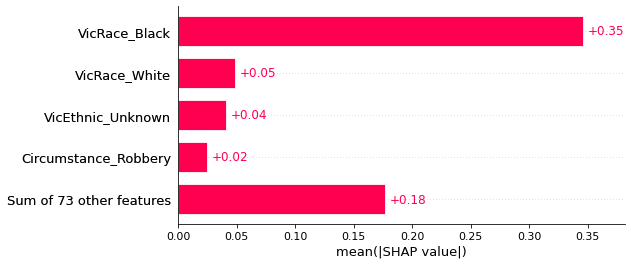

OffEthnic_Not of Hispanic origin


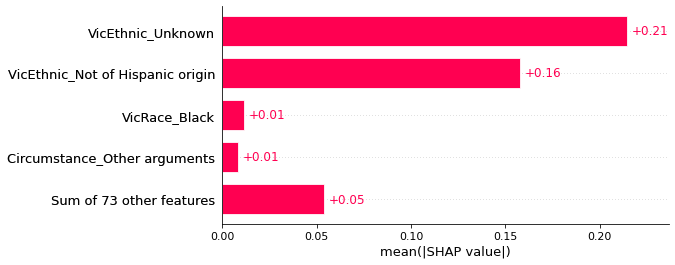

OffEthnic_Hispanic origin


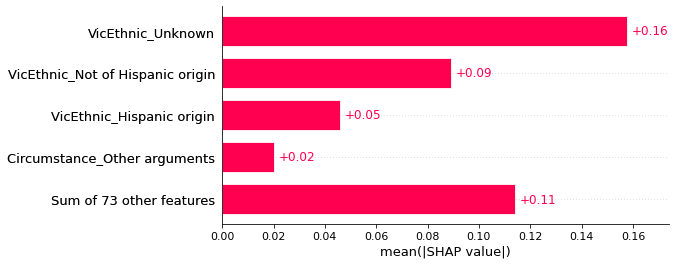

OffRace_Asian


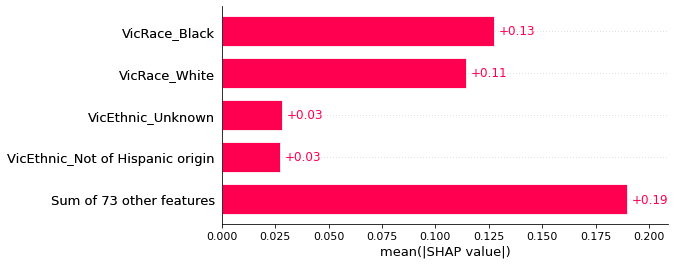

Relationship_In-law


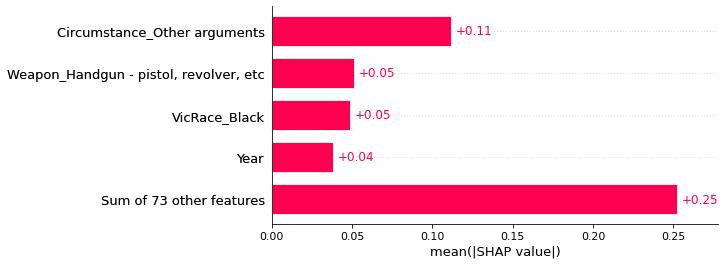

OffSex_Male


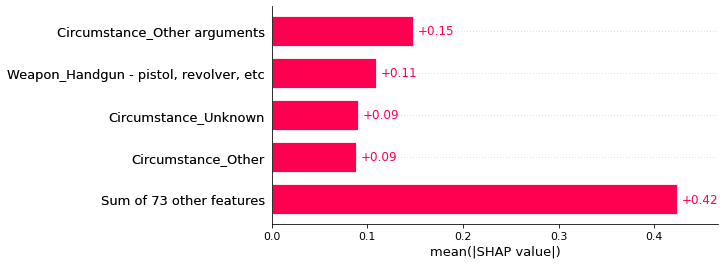

OffAge_80+


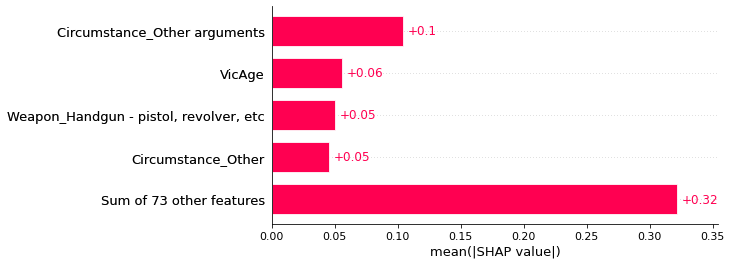

OffAge_23-30


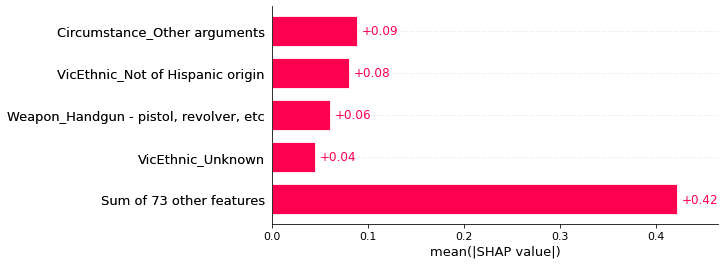

OffSex_Female


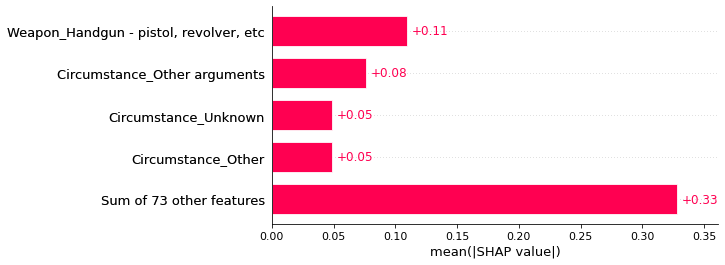

Relationship_Acquaintance


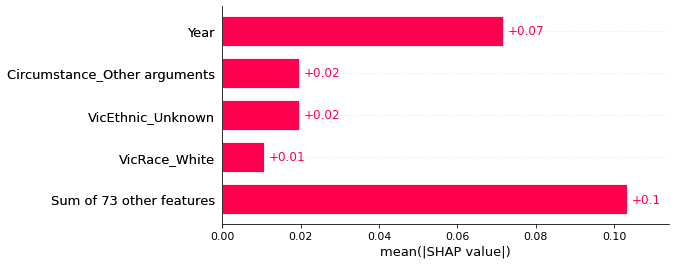

Relationship_Other family


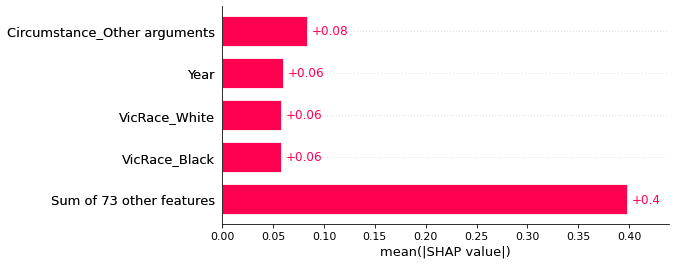

Relationship_Unknown


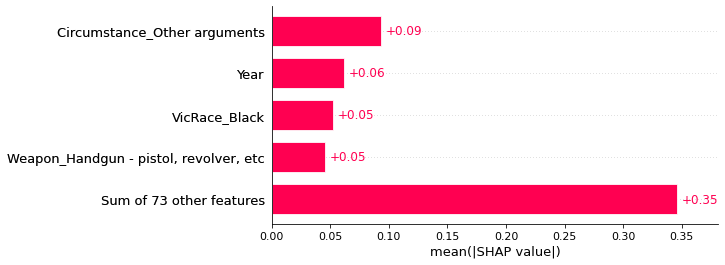

Relationship_Son


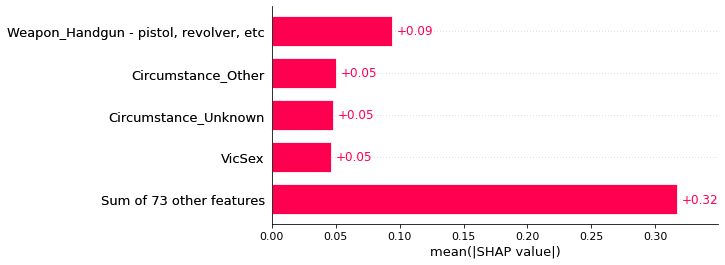

Relationship_Other - known to victim


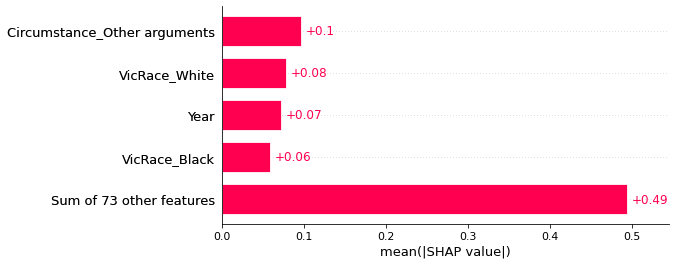

OffAge_15-18


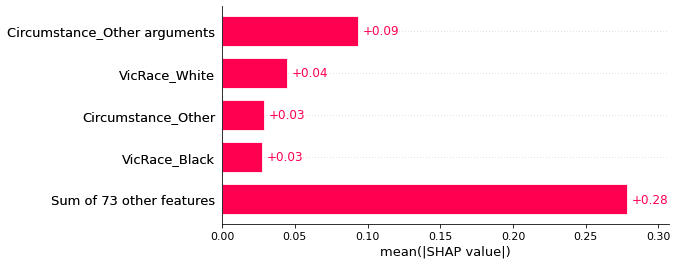

Relationship_Stepmother


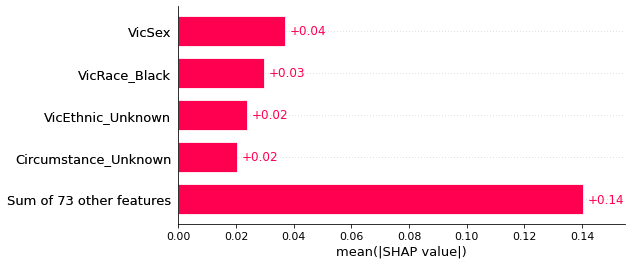

Relationship_Mother


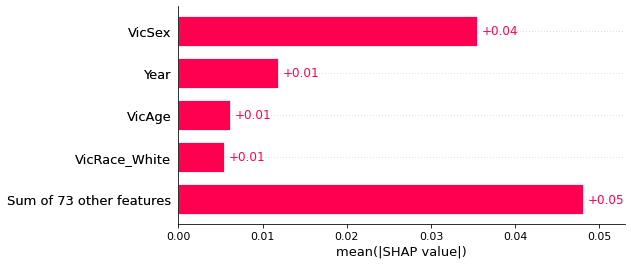

OffCount


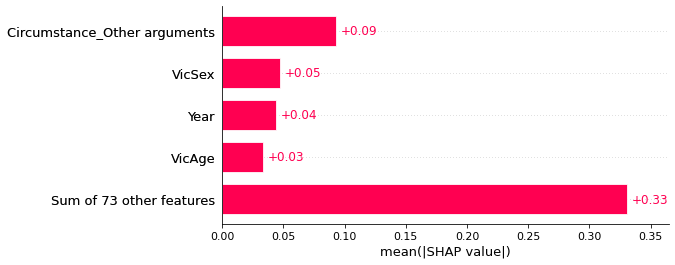

Relationship_Homosexual relationship


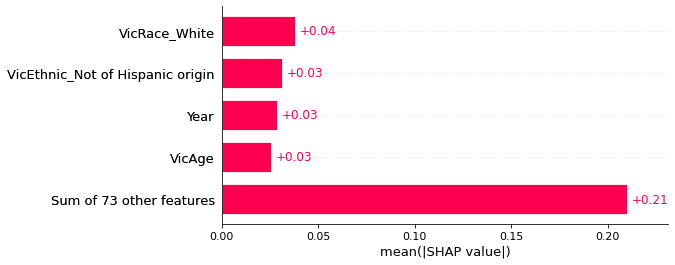

OffRace_White


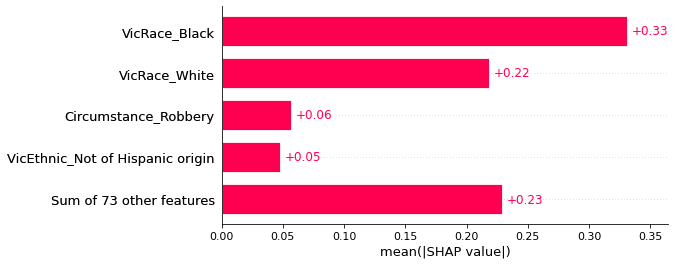

Relationship_Brother


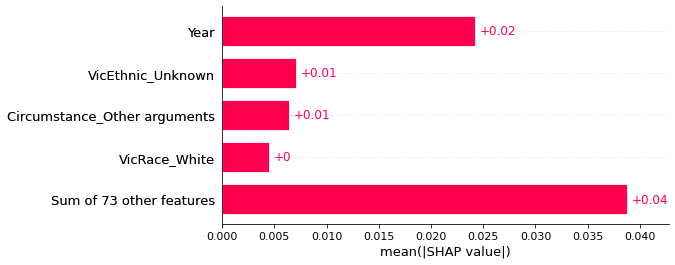

Relationship_Neighbor


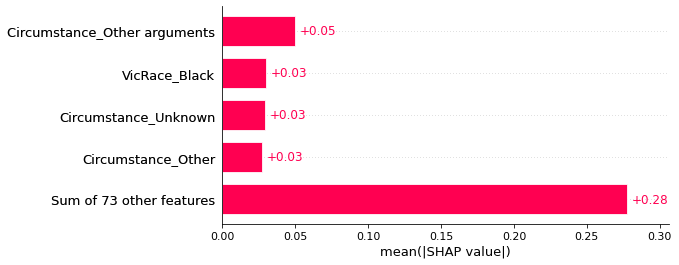

OffAge_70s


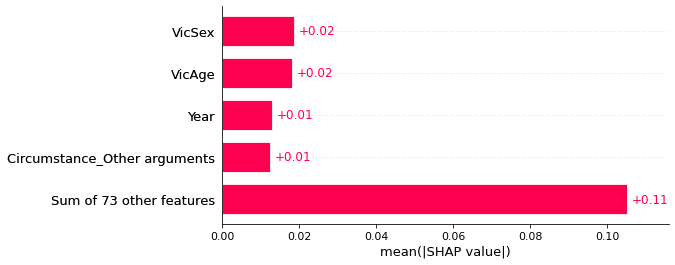

Relationship_Husband


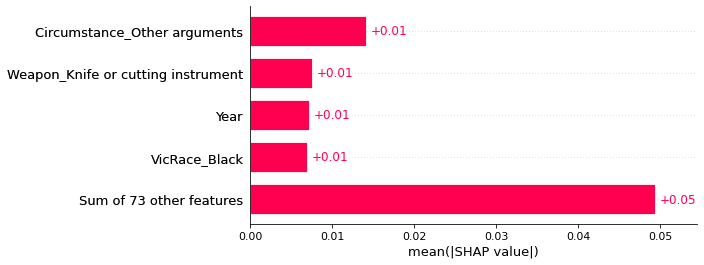

Relationship_Boyfriend


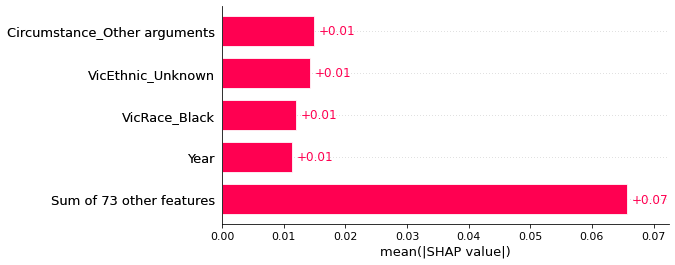

Relationship_Employer


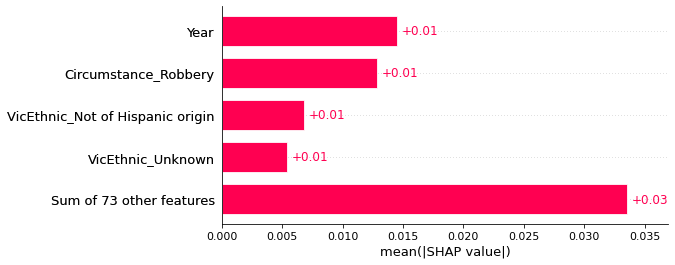

Relationship_Ex-wife


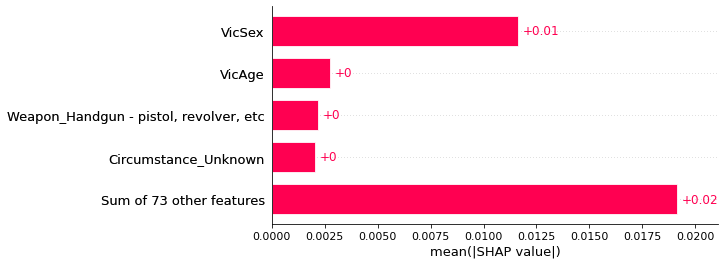

Relationship_Common-law husband


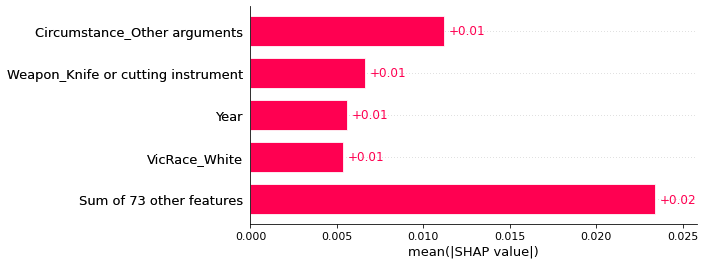

Relationship_Wife


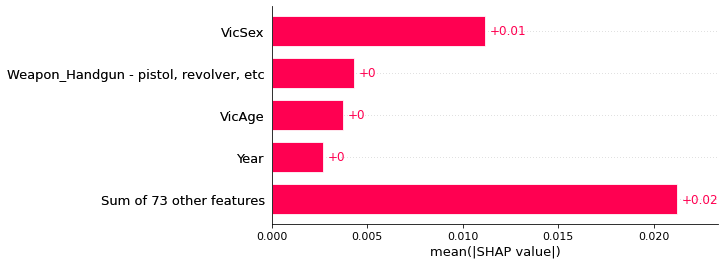

Relationship_Sister


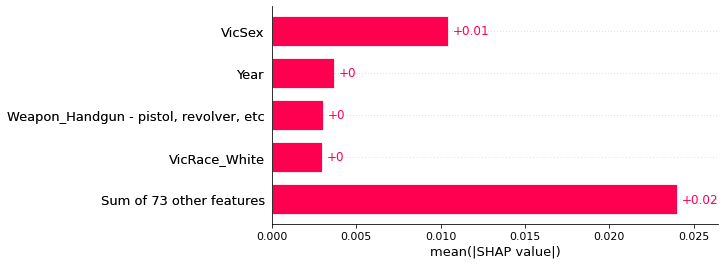

Relationship_Stranger


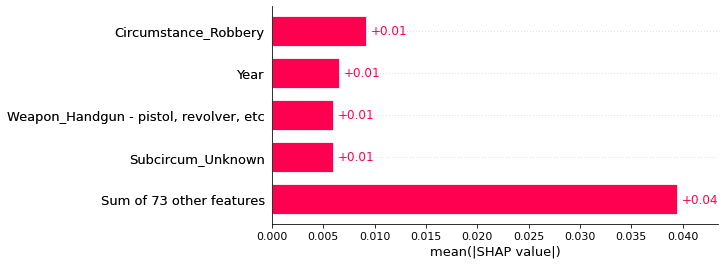

OffRace_American Indian or Alaskan Native


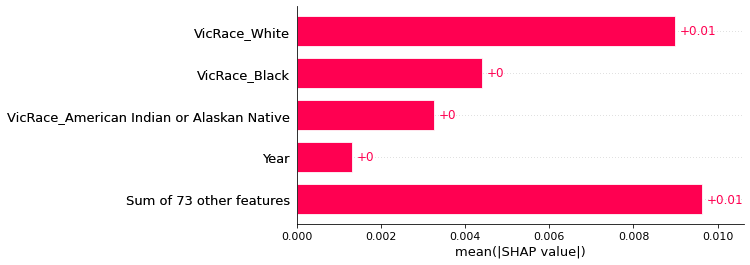

Relationship_Daughter


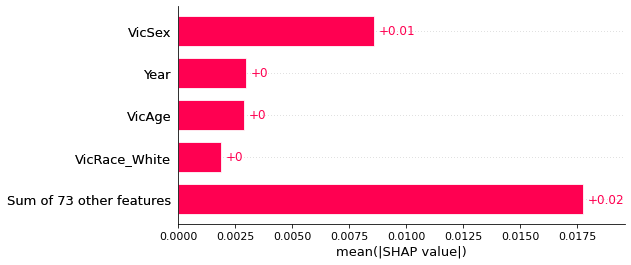

OffAge_3-14


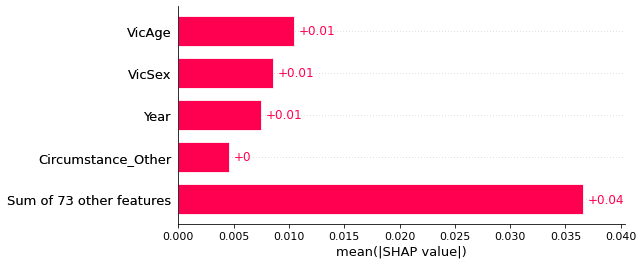

OffAge_40s


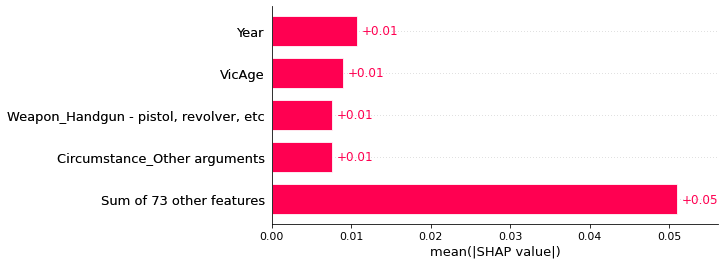

Relationship_Stepfather


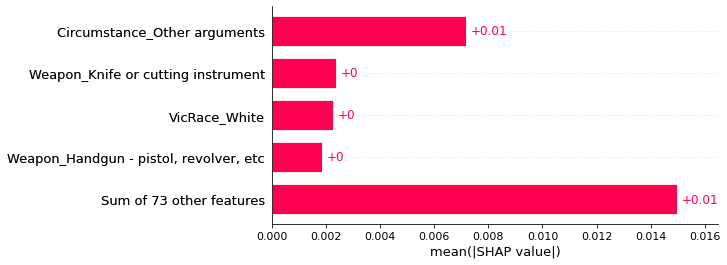

Relationship_Girlfriend


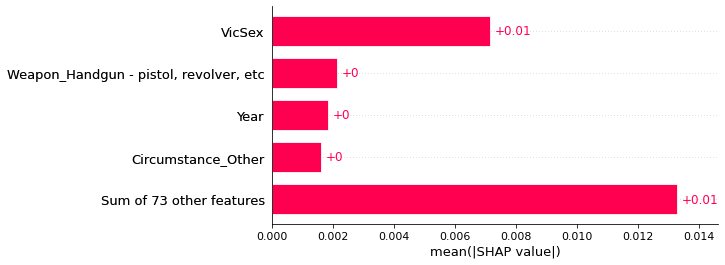

OffAge_19-22


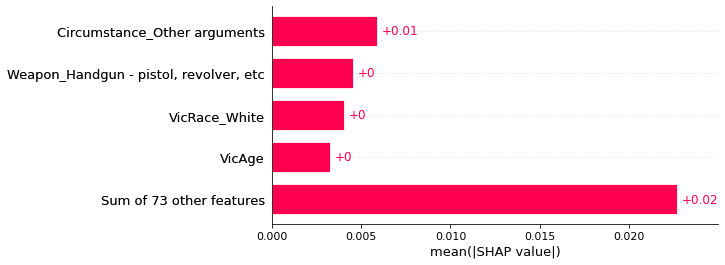

OffAge_50s


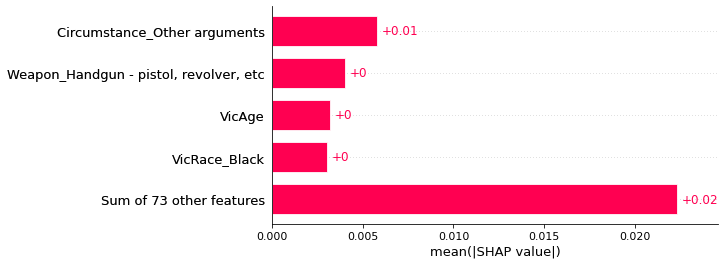

OffEthnic_Unknown


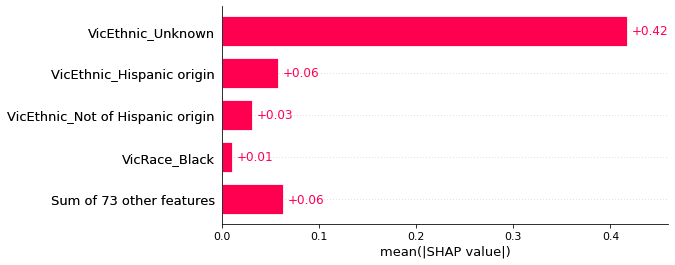

Relationship_Ex-husband


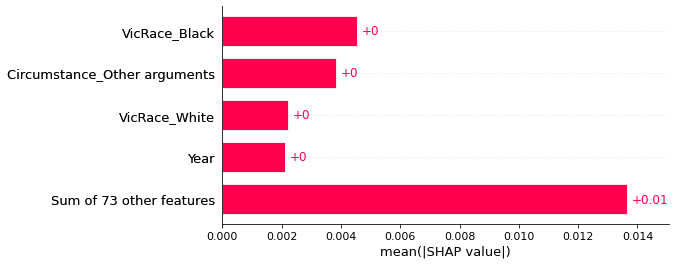

Relationship_Friend


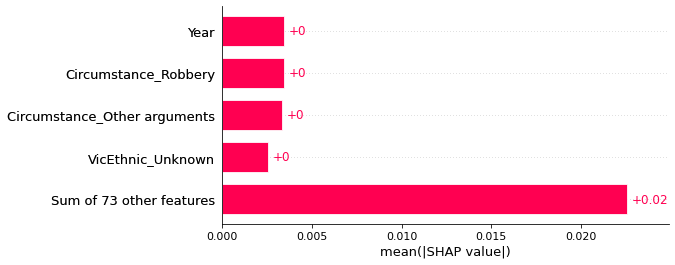

Relationship_Stepdaughter


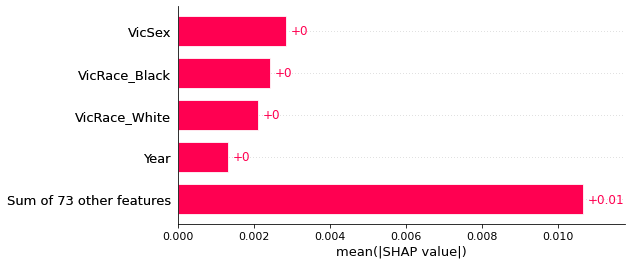

OffAge_999


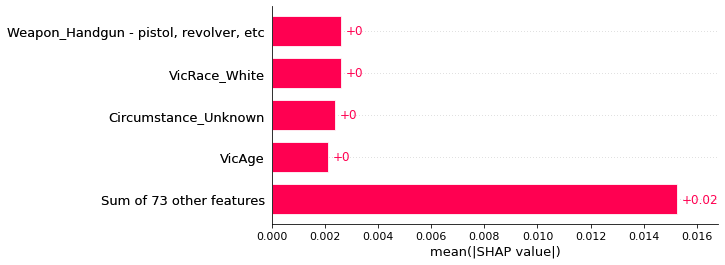

Relationship_Common-law wife


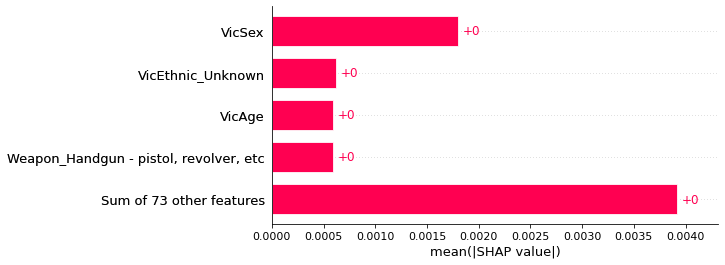

Relationship_Employee


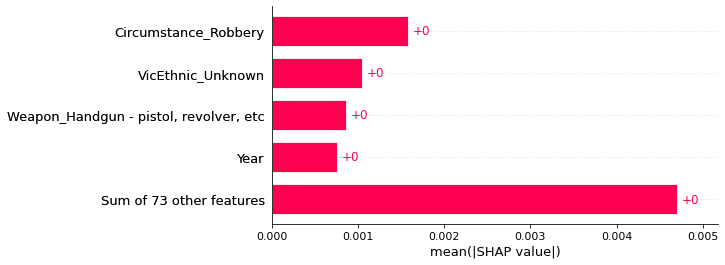

OffAge_0-2


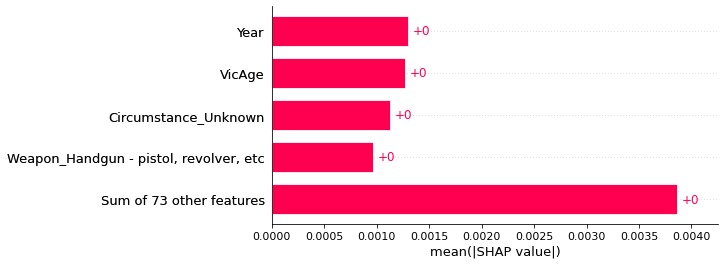

OffAge_60s


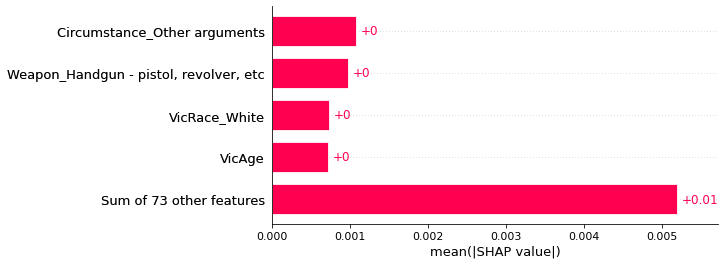

Relationship_Father


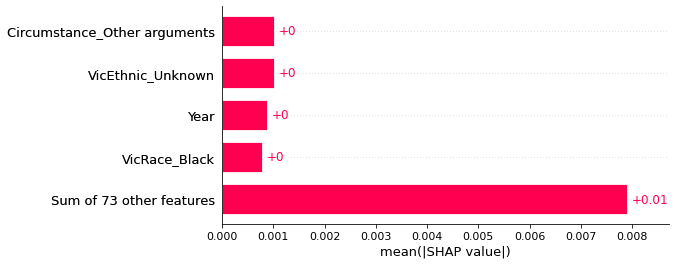

OffAge_30s


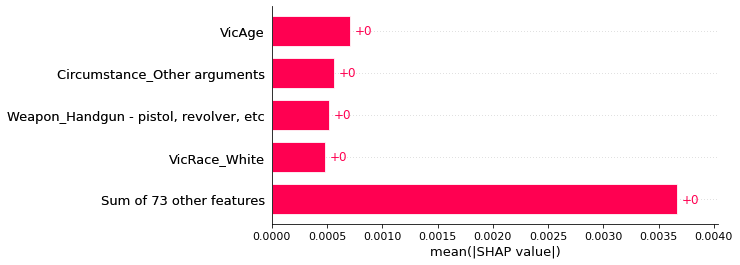

Relationship_Stepson


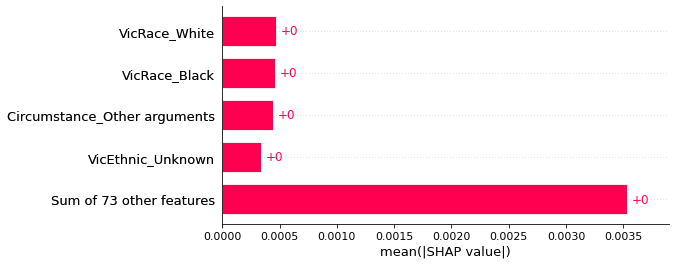

OffRace_Native Hawaiian or Pacific Islander


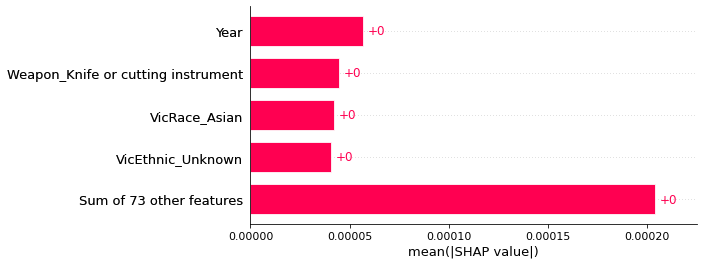

In [146]:
print("Output with the least explainability: ")
for i in range(52):
    ind = sorted_cols[len(Y_test.columns)-1-i]
    print(Y_test.columns[ind])
    shap.plots.bar(shaps[ind],max_display = 5)

    

In [413]:
f = lambda x: model.predict(x)

med = shap.utils.sample(X_test, nsamples=100, random_state=0)
med_k = shap.kmeans(X_test,100) 

In [428]:
explainer_perm = shap.explainers.Permutation(model.predict_proba, X_test)
shap_values_perm = explainer_perm(med_k.data)





















































































































































































Permutation explainer: 101it [01:24,  1.20it/s]


In [390]:
print("Output with the least explainability: ")
for i in range(6):
    print(Y_test.columns[sorted_cols[i]])


Output with the least explainability: 
OffAge_30s
OffAge_19-22
Relationship_Husband
OffAge_999
Relationship_Brother
Relationship_Wife


In [481]:
def plot_ice(y,thresh):
    i = 0
    for x in med.columns:
        
        val = np.unique(X_train[x])
            
        pred = []
        
        for v in val:
            med_k2 = np.array(med_k.data.copy())
            med_k2[i,:] =v
            preds2 = model_cb.predict(med_k2)
            preds2 = preds2.T
            pred.append(np.mean(preds2[0][y]))
        
        if max(pred) - min(pred) > thresh:
            fig, (ice_ax) = plt.subplots( sharex=True, sharey=True, figsize=(3, 3))

            ice_ax.plot(val,pred)

            ice_ax.set_xlabel(x);

            ice_ax.set_ylabel(Y_val.columns[y]);
            t = 'ICE curves '+str(x)+" "
            ice_ax.set_title(t);
        i+=1

[ 0  1  2  3  4  5  6  7  8  9 10 11]
[ 0  1  2  3  4  5  6  7  8  9 10 11]
[ 0  1  2  3  4  5  6  7  8  9 10 11]
[ 0  1  2  3  4  5  6  7  8  9 10 11]
[ 0  1  2  3  4  5  6  7  8  9 10 11]
[ 0  1  2  3  4  5  6  7  8  9 10 11]
[ 0  1  2  3  4  5  6  7  8  9 10 11]
[ 0  1  2  3  4  5  6  7  8  9 10 11]
[ 0  1  2  3  4  5  6  7  8  9 10 11]
[ 0  1  2  3  4  5  6  7  8  9 10 11]
[ 0  1  2  3  4  5  6  7  8  9 10 11]
[ 0  1  2  3  4  5  6  7  8  9 10 11]
[ 0  1  2  3  4  5  6  7  8  9 10 11]
[ 0  1  2  3  4  5  6  7  8  9 10 11]
[ 0  1  2  3  4  5  6  7  8  9 10 11]
[ 0  1  2  3  4  5  6  7  8  9 10 11]
[ 0  1  2  3  4  5  6  7  8  9 10 11]
[ 0  1  2  3  4  5  6  7  8  9 10 11]
[ 0  1  2  3  4  5  6  7  8  9 10 11]
[ 0  1  2  3  4  5  6  7  8  9 10 11]
[ 0  1  2  3  4  5  6  7  8  9 10 11]
[ 0  1  2  3  4  5  6  7  8  9 10 11]
[ 0  1  2  3  4  5  6  7  8  9 10 11]
[ 0  1  2  3  4  5  6  7  8  9 10 11]
[ 0  1  2  3  4  5  6  7  8  9 10 11]
[ 0  1  2  3  4  5  6  7  8  9 10 11]
[ 0  1  2  3

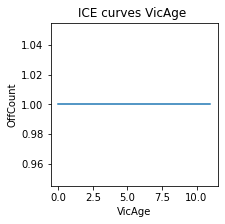

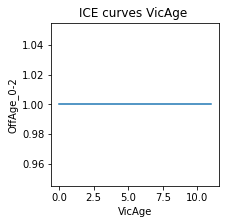

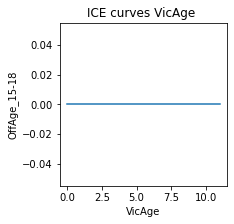

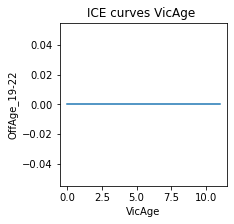

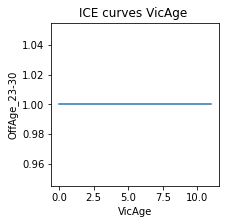

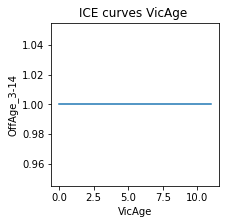

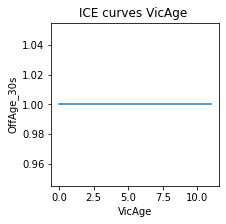

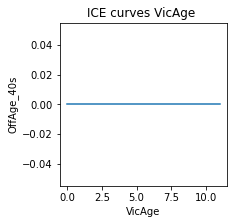

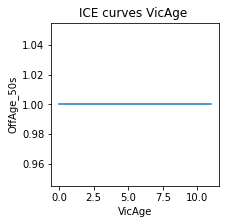

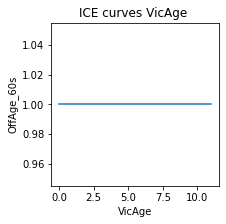

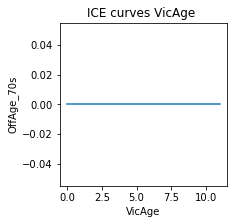

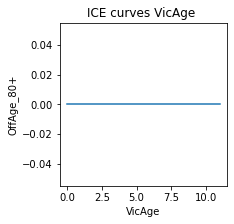

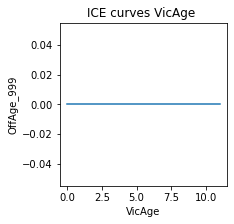

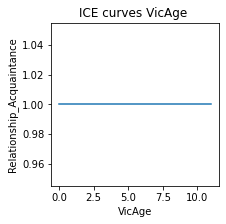

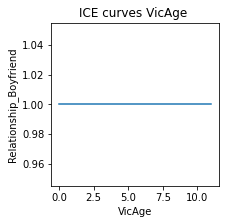

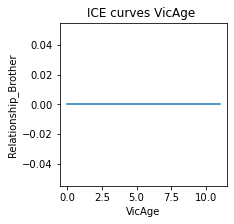

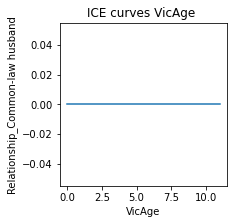

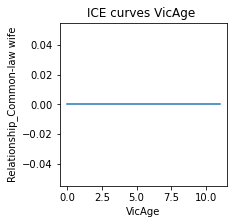

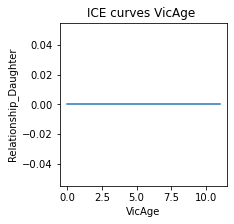

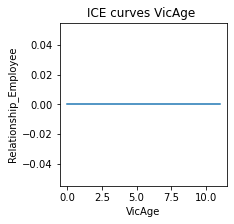

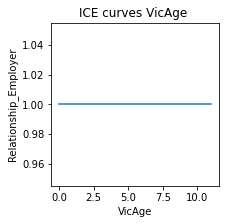

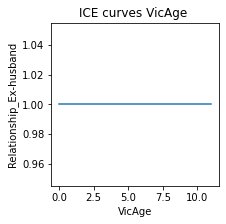

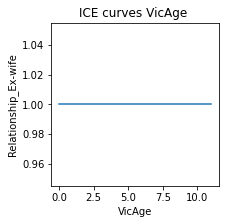

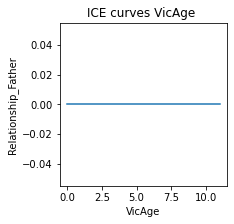

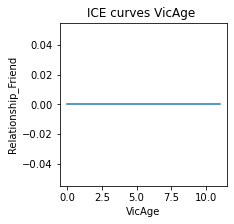

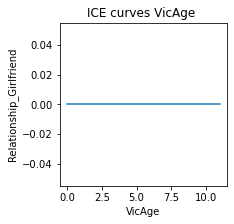

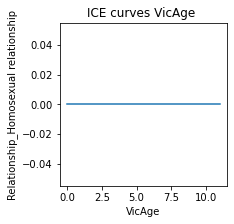

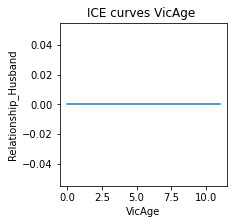

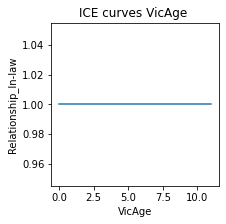

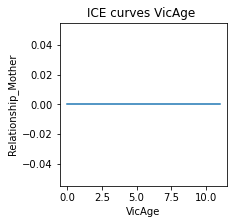

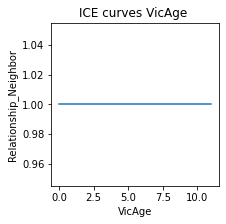

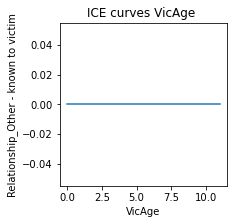

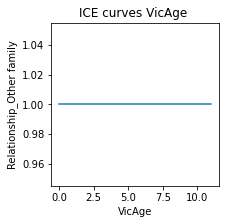

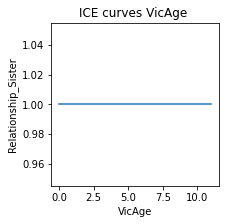

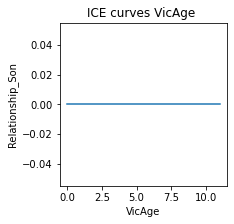

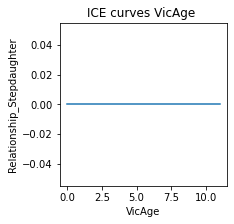

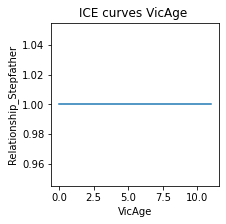

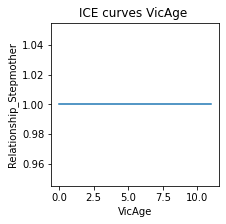

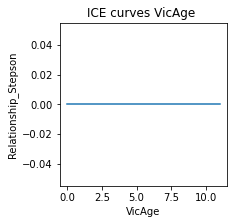

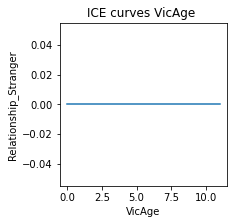

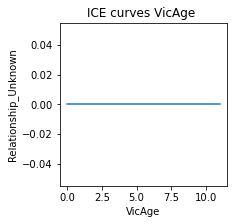

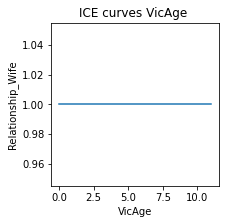

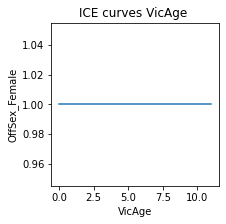

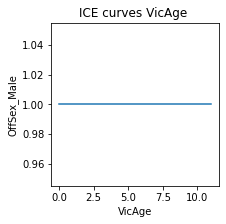

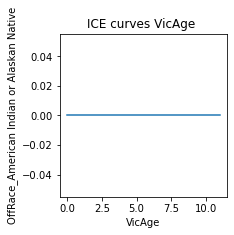

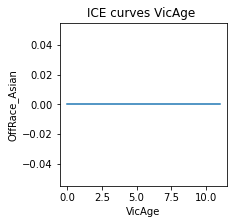

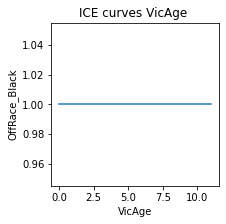

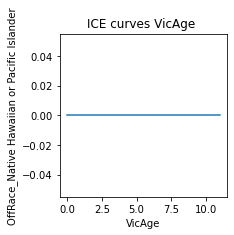

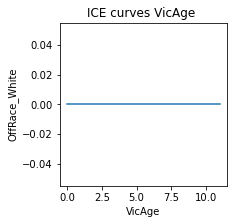

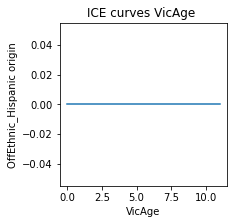

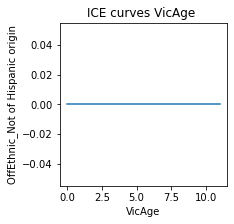

In [505]:
preds = model_cb.predict(X_test)
preds = preds.T

x = "VicAge"

for i in range(51):
    y =i
    val = np.sort(np.unique(X_train[x]))

    print(val)
                
    pred = []
    ind_x = np.where(X_train.columns == x)[0]
    for v in val:
        med_k2 = np.array(med_k.data.copy())
        med_k2[ind_x,:] =v
        preds2 = model_cb.predict(med_k2)
        preds2 = preds2.T
        pred.append(np.max(preds2[0][y]))
                
    fig, (ice_ax) = plt.subplots( sharex=True, sharey=True, figsize=(3, 3))
    ice_ax.plot(val,pred)

    ice_ax.set_xlabel(x);

    ice_ax.set_ylabel(Y_val.columns[y]);
    t = 'ICE curves '+str(x)+" "
    ice_ax.set_title(t);